实验目的：把SVM看成梯度下降来实现，自定义SVM。

随后将自定义的SVM分类用于 iris data(鸢尾花数据)； 取花瓣长度 和 花瓣宽度特征， 分类 看是不是 分类2的花 （(iris.target == 2)

对比下sklearn的SVM分类 和 自定义SVM分类 实现的分类效果

# 一、加载数据集（sklearn库中的IRIS数据集）

In [1]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)             # 这里转换成DataFrame的原因是可以对数据进行描述
X_pd = iris["data"]
y_pd = iris["target"]

In [2]:
X_pd.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [3]:
X_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [4]:
y_pd.info()

<class 'pandas.core.series.Series'>
RangeIndex: 150 entries, 0 to 149
Series name: target
Non-Null Count  Dtype
--------------  -----
150 non-null    int32
dtypes: int32(1)
memory usage: 728.0 bytes


In [5]:
y_pd.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

# 二、分离数据集

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
X, y = X_pd.to_numpy(), y_pd.to_numpy()
# X只取花瓣长度和宽度
X = X[:, [2, 3]]
# y 转换为两类的标签（是不是Virginica花）即是不是第二类花
y = np.array((y == 2), dtype=np.int8)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape, y_train.shape

((120, 2), (120,))

# 三、SVM分类器的原理

## 线性SVM分类器的工作过程

SVM的目标是找到一个超平面 $\mathbf{w}^T x + b = 0$，使得**间隔最大化**,间隔的计算公式为：
$$
Margin = \frac{2}{||\mathbf{w}||}
$$
其中：

- $\mathbf{w}是超平面的法向量（权重向量）$
- $||\mathbf{w}||$ 是 $\mathbf{w}$ 的 L2范数
<br/>

> **为什么间隔是$\frac{2}{||\mathbf{w}||}$ ?**<br/><br/>
> 决策边界：$\mathbf{w}^T x + b = 0$<br/><br/>
> 支持向量满足 $|\mathbf{w}^T x + b| = 1$(硬间隔情况)<br/><br/>
> 两个支持向量（正类和负类）到决策边界的距离之和就是间隔：
$$
Distance_+ = \frac{1}{||\mathbf{w}||}, Distance_- = \frac{1}{||\mathbf{w}||}
$$
$$
Margin = Distance_+ + Distance_- = \frac{2}{||\mathbf{w}||}
$$

---
### 1、训练
- 第一个目标：需要找到权重w和偏置b，使街道间隔尽可能宽。
- 第二个目标：限制落在街道内的实例的数量，以及分类错误的数量（街道内 + 街道外）
<br/>

### 2、 预测
线性 SVM 分类器的预测方式为

对于决策函数 $z = \mathbf{w}^T x + b$ 来说，预测的结果为：
$$
\hat{y} = \text{sgn}(z) =
\begin{cases}
1 \ \ \ \ \  (阳性) ,& \text{if} \ \ \  \mathbf{w}^T x + b \gt 0 \\
-1\  \ (阴性), & \text{if} \ \ \ \mathbf{w}^T x + b < 0
\end{cases}
$$

另外，$\mathbf{w}^T x + b = 0$ 为决策超平面

## 硬间隔和软间隔

### 1、硬间隔
在此情况下，所有样本均可正确分类，即存在一个超平面能完美分开两类（真实世界一般不存在）

### 2、软间隔
在此情况下，允许部分样本违反间隔规则，所以必须对违规样本进行惩罚

下面通过图像来直观理解什么是软硬间隔，这里使用SVC中C参数（惩罚因子）来模拟SVM中的软硬间隔，较大的C表示惩罚变大（类似于硬间隔），较小的C则惩罚较小（类似于软间隔）

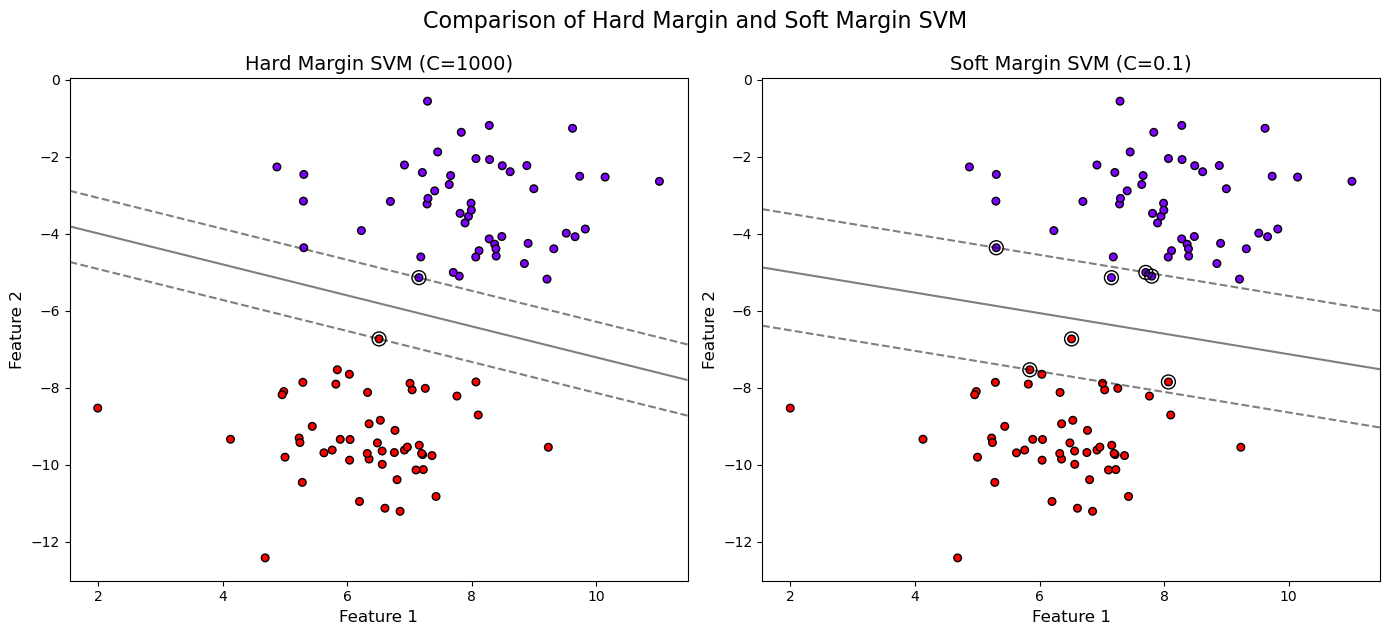

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

# 创建数据 - 部分重叠的数据集
X, y = make_blobs(n_samples=100, centers=2, random_state=6, cluster_std=1.2)
y = 2 * y - 1           # 转换为-1/1标签

# 创建两个SVM模型
hard_margin_clf = SVC(kernel='linear', C=1000)  # 硬间隔(大C值)
soft_margin_clf = SVC(kernel='linear', C=0.1)   # 软间隔(小C值)
hard_margin_clf.fit(X, y)
soft_margin_clf.fit(X, y)

# 创建绘图区域
plt.figure(figsize=(14, 6))

# 函数：绘制决策边界和支持向量
def plot_svm_boundary(ax, clf, X, y, title):
    # 绘制数据点
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap="rainbow", edgecolors='k')

    # 创建网格
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # 绘制决策边界和间隔
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # 标记支持向量
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

    # 标记误分类点(仅对软间隔)
    if title == "Soft Margin SVM (C=0.1)":
        y_pred = clf.predict(X)
        misclassified = np.where(y_pred != y)
        ax.scatter(X[misclassified, 0], X[misclassified, 1], s=150,
                   linewidth=1, facecolors='none', edgecolors='red', linestyle='--')

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)

# 绘制硬间隔SVM
ax1 = plt.subplot(1, 2, 1)
plot_svm_boundary(ax1, hard_margin_clf, X, y, "Hard Margin SVM (C=1000)")

# 绘制软间隔SVM
ax2 = plt.subplot(1, 2, 2)
plot_svm_boundary(ax2, soft_margin_clf, X, y, "Soft Margin SVM (C=0.1)")

plt.tight_layout()
plt.suptitle("Comparison of Hard Margin and Soft Margin SVM", y=1.05, fontsize=16)
plt.show()

## 硬间隔和软间隔对应的优化目标

1.硬间隔线性 SVM 分类器的目标看作一个约束优化问题，如下面公式所示。

$$
\begin{aligned}
\min_{\mathbf{w}, b} \quad & \frac{1}{2} \mathbf{w}^T \mathbf{w} \\\\
\text{满足} \quad & y_i (\mathbf{w}^T x_i + b) \geq 1, \quad i = 1, 2, \cdots, m
\end{aligned}
$$

其中：

- $\mathbf{w}$ 为权重向量，$b$ 为偏置
- $y_i \in \{-1,1\}$ 是样本标签
- $||\mathbf{w}||^2$($\mathbf{w}^T \mathbf{w}$) 控制超平面的复杂度
- 第二个式子的约束条件**保证**所有样本均被正确分类且位于间隔外

<br/>
2.软间隔线性 SVM 分类器目标可看做如下的约束优化问题，如下所示：

$$
\begin{aligned}
\min_{\mathbf{w}, b, \boldsymbol{\zeta}} \quad & \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \sum_{i=1}^m \zeta_i \\\\
\text{使得} \quad & y_i (\mathbf{w}^T x_i + b) \geq 1 - \zeta_i, \quad \zeta_i \geq 0,\quad i = 1, 2, \cdots, m
\end{aligned}
$$

其中：

- $\mathbf{w}$ 为权重向量，$b$ 为偏置
- $y_i \in \{-1,1\}$ 是样本标签
- $||\mathbf{w}||^2$($\mathbf{w}^T \mathbf{w}$) 控制超平面的复杂度
- $\zeta_i$ 是松弛变量，表示第 $i$ 个样本的违反程度（$\zeta_i > 0$ 表示样本位于间隔内或分类错误）
- $C$ 是惩罚系数，控制对误分类的容忍度；$C$越大 --> 模型越严格，$C$越小 --> 模型越宽松，允许更多误分类


硬间隔和软间隔问题都属于凸优化问题，而上述问题还需通过求解其对偶问题以及应用核技巧（Kernel Trick）来求解较为繁杂


## 梯度下降模拟SVM

### 1、损失函数
一个重要的hinge/平方hinge损失函数：
$$
L_{hinge} = \max(0, 1 - y_i(\mathbf{w}^\top \mathbf{x}_i + b))
$$
$$
L_{square\_hinge} = \bigl[\max(0, 1 - y_i(\mathbf{w}^\top \mathbf{x}_i + b))\bigl]^2
$$
其中 $L_{hinge}$ 和软间隔的第二个约束条件 $y_i (\mathbf{w}^T x_i + b) \geq 1 - \zeta_i ,\ \zeta_i \geq 0$ 完全等价

我们再添加上第一个条件，则SVM的优化目标可写成一个式子，如下：
$$
\min_{\mathbf{w}, b} \quad \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \max(0, 1 - y_i(\mathbf{w}^\top \mathbf{x}_i + b))
$$

则，SVM的损失函数可以抽象为如下形式：
$$
\boxed{
\color{#d65745}
J(\mathbf{w}, b) \;=\; \frac{1}{m} \sum_{i=1}^m \max\big(0, \, 1 - y_i(\mathbf{w}^T \mathbf{x}_i + b) \big) \;+\; \frac{1}{2 C m} \|\mathbf{w}\|^2
}
$$
其中：

- 第一项为hinge损失函数，只在 “没被正确分类/分到了间隔内” 时才有损失
- 第二项：L2 正则化项，C为正则化强度的倒数
    - **$C$ 大** → 正则化系数 $1/(2Cm)$ 小 → 更重视分类误差（拟合能力 ↑，偏差 ↓，方差 ↑）
    - **$C$ 小** → 正则化系数大 → 更重视间距（泛化能力 ↑，偏差 ↑，方差 ↓）

所以，对于如上的损失函数 $J(\mathbf{w}, b)$ 来进行梯度下降

### 2、计算梯度
定义违规（有损失）掩码向量 $ \mathbf{m} \in \{0,1\}^m $：

$$
m_i =
\begin{cases}
1, & y_i f_i < 1 \\
0, & 其他
\end{cases}
$$


- 则损失函数$J(\mathbf{w}, b)$梯度为：

$$
\boxed{
g_w =
\nabla_{\mathbf{w}} J
= \frac{2\lambda}{m} \mathbf{w} - \frac{1}{m} X^\top \big( \mathbf{y} \odot \mathbf{m} \big)
}
$$
其中, $\lambda = 1/(2C)$, 符号 $ \odot $ 表示为矩阵的哈达玛积（即对应元素相乘）
$$
\boxed{
g_b =
\nabla_b J
= -\frac{1}{m} \sum_{i=1}^m y_i m_i
= -\frac{1}{m} \mathbf{y}^\top \mathbf{m}
}
$$



### 3、梯度下降更新迭代公式
$$
w \leftarrow w - \eta g_w
$$
$$
b \leftarrow b - \eta g_b
$$
其中，$\eta$是人为设置的学习率

# 四、自定义SVM分类器（SVC）

**对于SVC来说，其支持向量为处于间隔内的向量或分类错误的向量，即满足$ \mathbf{w}^T \mathbf{x}_i + b < 1 $的所有$\mathbf{x}_i$**

**即下面公式中所有的 $\mathbf{x}_i$都是SVC的支持向量**

则，SVC的损失函数转变为：
$$
J(\mathbf{w}, b) \;=\; \frac{1}{m} \sum_{i=1}^m  \, \bigl[1 - y_i(\mathbf{w}^T \mathbf{x}_i + b) \bigl] \;+\; \frac{1}{2 C m} \|\mathbf{w}\|^2
$$
或者为：
$$
J(\mathbf{w}, b) \;=\; \frac{1}{m} \sum_{i=1}^m  \, \bigl[1 - y_i(\mathbf{w}^T \mathbf{x}_i + b) \bigl] \;+\; \frac{\lambda}{m} \|\mathbf{w}\|^2
$$
上面两个式子无本质区别，第一个式子是为了符合sklearn中SVC的C参数的设计理念，第二个式子是可以直观地看到正则化强度对损失函数的影响，显然，$\lambda = 1/2C$ (后续会沿用这个设置)

对上述损失函数求梯度，得：
$$
\boxed{
g_w =
\nabla_{\mathbf{w}} J
= \frac{2\lambda}{m} \mathbf{w} - \frac{1}{m} X^\top \mathbf{y}
}
$$

$$
\boxed{
g_b =
\nabla_b J
= -\frac{1}{m} \sum_{i=1}^m y_i
}
$$

梯度下降的迭代公式为：
$$
w \leftarrow w - \eta g_w
$$
$$
b \leftarrow b - \eta g_b
$$
其中，$\eta$是人为设置的学习率

In [9]:
# 自定义SVM分类器（SVC）
from sklearn.base import BaseEstimator
import numpy as np

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1.0, eta=0.1, n_epochs=1000, random_state=None):
        """

        :param C: 正则化强度的倒数，以符合sklearn库中SVC中C参数的特性
        :param eta: 学习率
        :param n_epochs: 迭代的轮次数
        :param random_state: 随机数种子，设置以复现结果
        """
        self.C = C
        self._lambda = 1 / (2*C)        # 正则化强度 lambda
        self.eta = eta
        self.n_epochs = n_epochs
        self.random_state = random_state


    def fit(self, X, y):
        """
        这里要做的工作有：计算梯度和梯度下降
        :param X: 样本  形状 (m,n)
        :param y: 分类标签，(m, )
        :return: self
        """
        # 随机初始化，如果给了random_state，则设置随机数种子，以复现结果
        if self.random_state:
            np.random.seed(self.random_state)

        # 初始化权重向量和偏置
        w = np.random.randn(X.shape[1], 1)      # (n, 1)
        b = np.random.randn()

        m = X.shape[0]
        self.J_history = []

        # 分类0/1转换为分类-1/1
        if np.any(y) != -1:
            y = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1

        # 训练
        for i in range(self.n_epochs):
            # 找出支持向量,对于SVC来说，支持向量是在间隔内的向量或者分类错误的向量
            support_vector_idx = ((X@w + b)*y < 1).ravel()
            X_sv = X[support_vector_idx]
            y_sv = y[support_vector_idx]

            # 损失函数
            J = (np.sum(1 - y_sv * (X_sv@w + b)) + self._lambda*np.sum(w ** 2)) / m
            self.J_history.append(J)

            # 计算梯度以及梯度下降
            g_w = (2 * self._lambda * w - X_sv.T @ y_sv) / m
            g_b = -np.sum(y_sv) / m

            w = w - self.eta * g_w
            b = b - self.eta * g_b

        self.intercept_ = b
        self.coef_ = w
        support_vector_idx = ((X@w + b)*y < 1).ravel()
        self.support_vectors_ = X[support_vector_idx]
        return self

    # 决策超平面
    def decision_function(self, X):
        return X @ self.coef_ + self.intercept_

    # 预测分类为阳性的概率
    def predict(self, X):
        return self.decision_function(X) >= 0

# 五、模型测试

In [10]:
# 用默认参数跑
my_svc_model = MyLinearSVC(random_state=42)
my_svc_model.fit(X_train, y_train)

MyLinearSVC(random_state=42)

In [11]:
from sklearn.metrics import accuracy_score
accuracy_rate = accuracy_score(y_test, my_svc_model.predict(X_test))
print(f"自定义的SVC准确率为: {accuracy_rate * 100:.3f} %")

自定义的SVC准确率为: 100.000 %


In [12]:
# 看一下训练出来的相关属性
print(f"权重向量 w 为：{my_svc_model.coef_.ravel()}")
print(f"偏置 b 为：{my_svc_model.intercept_}")
print(f"则超平面方程为：{my_svc_model.coef_.ravel()[0]:.3f} * x[0] + {my_svc_model.coef_.ravel()[1]:.3f} * x[1] {my_svc_model.intercept_:.3f} = 0")

权重向量 w 为：[0.41834332 2.18183513]
偏置 b 为：-5.5806447952326454
则超平面方程为：0.418 * x[0] + 2.182 * x[1] -5.581 = 0


其中，x[0]/[1]分别代表样本X的两个特征,
- x[0]代表花瓣长度（Petal length）
- x[1]代表花瓣宽度(Petal Width)

另外，有一点需要说明的是，对于超平面方程$\mathbf{w}^T x + b = 0$来说，不同的样本X有不同的决策超平面


In [13]:
from sklearn.svm import LinearSVC
lin_svc = LinearSVC(dual=True, random_state=42)
lin_svc.fit(X_train, y_train)

LinearSVC(dual=True, random_state=42)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_rate = accuracy_score(y_test, lin_svc.predict(X_test))
print(f"sklearn中的LinearSVC的准确率为: {accuracy_rate * 100:.3f} %")

sklearn中的LinearSVC的准确率为: 100.000 %


# 六、绘制相关图像

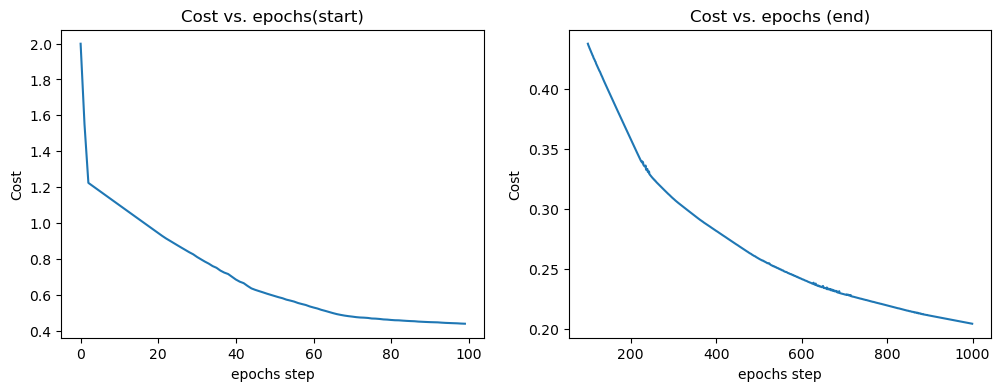

In [16]:
# 画损失值 和 迭代次数的关系
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(my_svc_model.J_history[:100])
ax2.plot(100 + np.arange(len(my_svc_model.J_history[100:])), my_svc_model.J_history[100:])
ax1.set_title("Cost vs. epochs(start)")
ax2.set_title("Cost vs. epochs (end)")
ax1.set_ylabel('Cost')
ax2.set_ylabel('Cost')
ax1.set_xlabel('epochs step')
ax2.set_xlabel('epochs step')
plt.show()

In [17]:
def plot_dataset(X, y, axes):
    # axes： 坐标轴的范围，列表
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    # axes: 坐标轴的范围，列表, [x上界，x下界, y轴上界,y轴下界]
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contour(x0, x1, y_decision, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--']) # 画间隔，间隔 根据决策分数=+1/-1决定


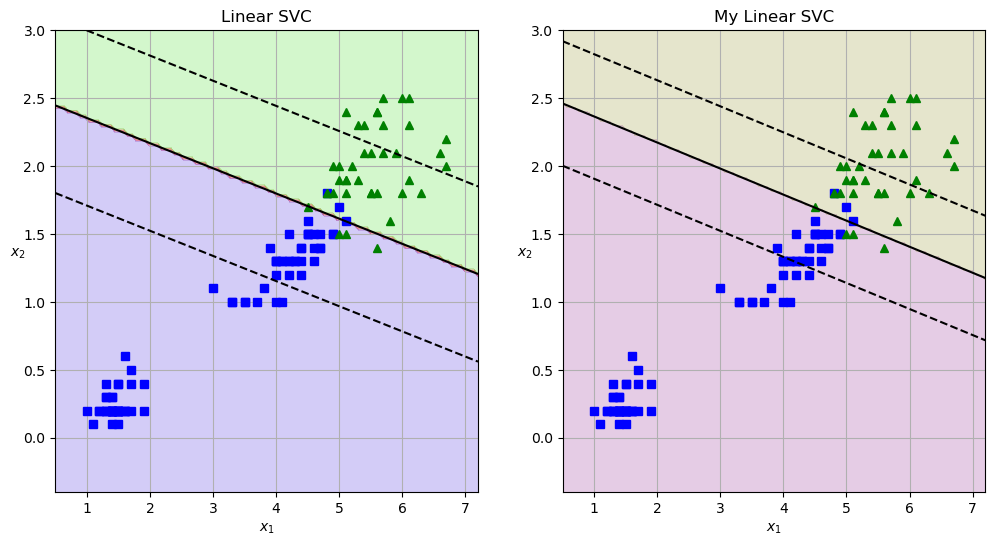

In [124]:
axes = [np.min(X_train[:,0]) - 0.5, np.max(X_train[:, 0]) + 0.5,
        np.min(X_train[:, 1]) - 0.5,np.max(X_train[:,1]) + 0.5]
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plot_dataset(X_train,y_train, axes)
plot_predictions(lin_svc, axes=axes)
plt.title("Linear SVC")

plt.subplot(1,2,2)
plot_dataset(X_train,y_train, axes)
plot_predictions(my_svc_model, axes=axes)
plt.title("My Linear SVC")

plt.show()